## Mark 4 (2018) fMRIQA Gel Phantom

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

try:
    import pydicom as dcm
except ImportError:
    import dicom as dcm

from scipy.optimize import curve_fit

In [2]:
# Replaces fetch from server with fetch from disc 
# from dcmfetch import fetch_series
def fetch_series(patid, sernos):
    """
    Fetch dicom series from disc.

    Assumes in current directory under path
        patid/seriesno/imageno.dcm
    
    """
    from os.path import join
    from glob import glob
    patterns = [
        join(patid, '%02d' % serno, '*.dcm')
        for serno in sernos
    ]
    files = sum((glob(p) for p in patterns), [])
    return [dcm.read_file(f) for f in files]

In [3]:
patid='FMRIQA20180831RHD'
series = {
    'Structural': [5],
    'T1': [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
    'T2': [10, 11, 12, 13, 14, 15],
}

## Structural Series

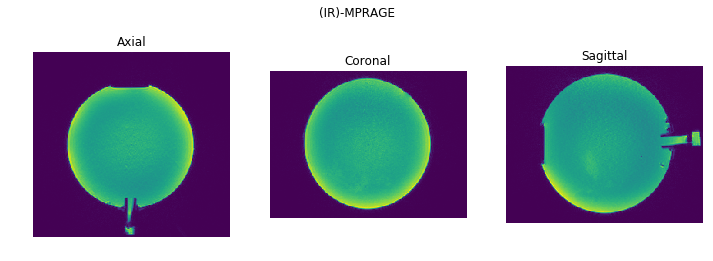

In [4]:
dobjs = sorted(
    fetch_series(patid=patid, sernos=series['Structural']),
    key=lambda d: float(d.SliceLocation)
)
structural = np.array([dobj.pixel_array for dobj in dobjs])
nz, ny, nx = structural.shape

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(structural[nz//2, : ,:])
axs[0].axis('off')
axs[0].set_title('Axial')
axs[1].imshow(structural[:, ny//2, :])
axs[1].axis('off')
axs[1].set_title('Coronal')
axs[2].imshow(structural[:, :, nx//2])
axs[2].axis('off')
axs[2].set_title('Sagittal')
fig.suptitle('(IR)-MPRAGE');

## T<sub>1</sub> Analysis

### Inversion Recovery Images

This is a turbo spin echo signed inversion recovery experiment at a range of different inversion times. We've one series (an image) per inversion time. However, we'll read them all together and use `pydicom` to sort according to the inversion time.

In [5]:
# We have just a single slice position which simplifies things a little
dobjs = sorted(
    fetch_series(patid=patid, sernos=series['T1']),
    key=lambda d: float(d.InversionTime)
)

rescale_slope = float(dobjs[0].RescaleSlope)
rescale_intercept = float(dobjs[0].RescaleIntercept)
assert all(float(d.RescaleSlope) == rescale_slope for d in dobjs)
assert all(float(d.RescaleIntercept) == rescale_intercept for d in dobjs)

# Construct arrays with all tis
vol = np.array([d.pixel_array for d in dobjs]) * rescale_slope + rescale_intercept

# Get the inversion times
tis = np.array([float(d.InversionTime) for d in dobjs])
ntis = len(tis)

We'll take a look at the images at the different inversion times.

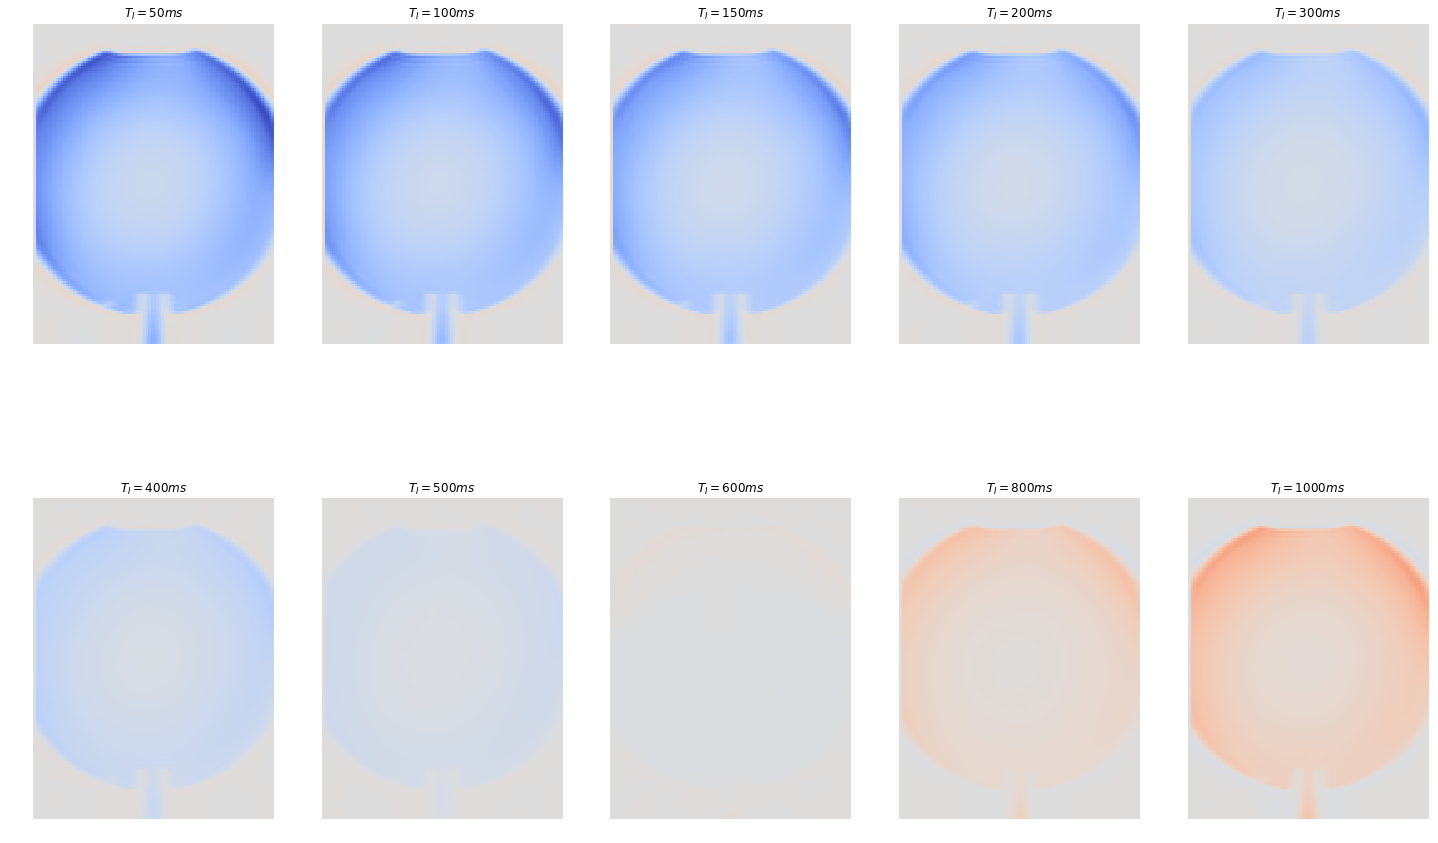

In [6]:
ncols = 5
nrows = int(np.ceil(ntis/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 8*nrows))

# Symmetric common data range
win_max = max(-vol.min(), vol.max())
win_min = -win_max
for i, ax in enumerate(axs.flat):
    if i < ntis:
        ax.imshow(vol[i], cmap='coolwarm', vmin=win_min, vmax=win_max)
        ax.set_title(r'$T_I=%d ms$' % int(tis[i]))
    else:
        ax.imshow(np.zeros_like(vol[0]), cmap='coolwarm', vmin=win_min, vmax=win_max)
    ax.axis('off')

The image is nulled at about 600 ms $T_I$ corresponding to a $T_1$ of about 870ms ($T_1 = \frac{T_{I, \mathrm{null}}}{\log 2}$).

### T<sub>1</sub> Decay

The expected signal as a function of $T_1$ is the mono-exponential recovery $M_0 (1 - 2 * e^{-T_I/T_1})$. This is what we'll fit to the data.

In [7]:
def ir_signal(ti, m0, t1):
    """
    The expected signal based on the T1 decay.
    Parameters
    ----------
    ti: inversion time
    m0: equilibrium magnetization
    t1: relaxation time

    Returns
    -------
    signal
    """
    return m0 * (1.0 - 2.0 * np.exp(-ti/t1))

### Phantom Mask
First, we'll generate a mask so as only to work on foreground pixels. The threshold here is arbitrary.

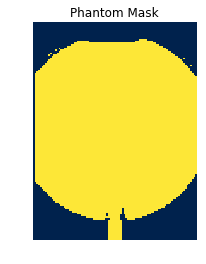

In [8]:
magnitude_image = abs(vol).mean(axis=0)
mask = magnitude_image > 0.42 * np.median(magnitude_image)
fig, ax = plt.subplots()
ax.imshow(mask, cmap='cividis')
ax.axis('off')
ax.set_title('Phantom Mask');

### Fitting T<sub>1</sub> Pixel by Pixel
Within the series we fit a $T_1$ decay at each pixel position to derive parametric images of $T_1$ and $M_0$.

In [9]:
def t1fit(signal_vals):
    m0_start = -signal_vals[0]
    t1_start = 500
    (m0_fit, t1_fit), _ = curve_fit(ir_signal, tis, signal_vals, (m0_start, t1_start))
    return m0_fit, t1_fit

def t1fitroi(roi, mask):
    assert roi.shape[1:] == mask.shape
    nti, ny, nx = roi.shape
    m0 = np.full_like(roi[0], np.NAN)
    t1 = np.full_like(roi[0], np.NAN)
    for y in range(ny):
        for x in range(nx):
            if mask[y, x]:
                signal_vals = roi[:, y, x]
                m0_fit, t1_fit = t1fit(signal_vals)
                m0[y, x] = m0_fit
                t1[y, x] = t1_fit
    return m0, t1

m0, t1 = t1fitroi(vol, mask)

### Plotting T<sub>1</sub> maps.

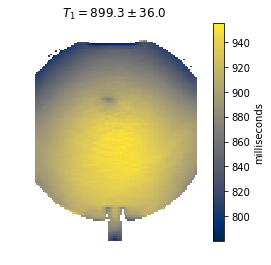

In [10]:
fig, ax = plt.subplots()
im = ax.imshow(t1, cmap='cividis', interpolation='nearest')
ax.axis('off')
cbar = fig.colorbar(im)
cbar.set_label('milliseconds')
ax.set_title(r'$T_1 = %0.1f \pm %0.1f$' % (np.nanmean(t1), np.nanstd(t1)));

The $T_1$ values are around 900ms which is slightly longer than expected (the previous phantom was about 800ms) but that is fine. There is rather more variability in the measurement than I'd have expected. I'm not sure why. It could be a flip angle variation, in which case that could be modelled as well. There's also a bit of a glitch in the middle of the phantom.

----

## T<sub>2</sub> Analysis

### Spin Echo Images

This is a conventional single echo spin echo series with a range of echo times. We've avoided the multi-contrast spin echo (CPMG) as variable refocussing flip angles make it unreliable.

In [11]:
# We have just a single slice position which simplifies things a little
dobjs = sorted(
    fetch_series(patid=patid, sernos=series['T2']),
    key=lambda d: float(d.EchoTime)
)

# Construct arrays with all tes
vol = np.array([d.pixel_array for d in dobjs], dtype=float)

# Get the echo times
tes = np.array([float(d.EchoTime) for d in dobjs])
ntes = len(tes)

We'll have a look at the images at the different echo times.

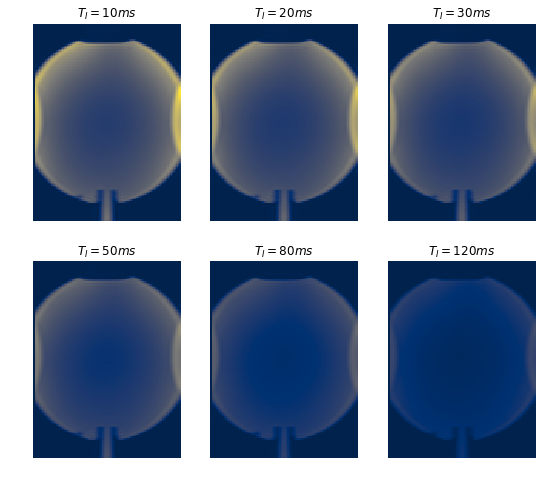

In [12]:
ncols = 3
nrows = int(np.ceil(ntes / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 4*nrows))

# Common data range
win_max = vol.max()
win_min = vol.min()
for i, ax in enumerate(axs.flat):
    if i < ntes:
        ax.imshow(vol[i], cmap='cividis', vmin=win_min, vmax=win_max)
        ax.set_title(r'$T_I=%d ms$' % int(tes[i]))
    else:
        ax.imshow(np.zeros_like(vol[0]), cmap='cividis', vmin=win_min, vmax=win_max)
    ax.axis('off')

### T<sub>2</sub> Decay

We'll model the $T_2$ decay as a mono-exponential decay with echo time.

The following function $M_0 e^{-T_E/T_2}$ is the expected signal based on the $T_2$. This is what we'll be trying to fit to the data.

In [13]:
def se_signal(te, m0, t2):
    ''' The expected signal based on the T2 decay.
        Parameters
        ----------
        te: echo time
        m0: equilibrium magnetization
        t2: relaxation time

        Returns
        -------
        signal
    '''
    return m0 * np.exp(-te/t2)

Extract a mask for the phantom foregound as before.

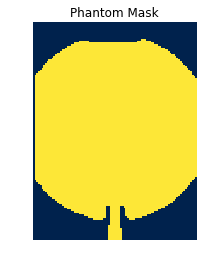

In [14]:
mean_image = vol.mean(axis=0)
mask = mean_image > 0.6 * np.median(mean_image)
fig, ax = plt.subplots()
ax.imshow(mask, cmap='cividis')
ax.axis('off')
ax.set_title('Phantom Mask');

### Fitting T<sub>2</sub> Pixel by Pixel

For each roi extract a series of images at the different $T_E$s. Then, for each of the regions we'll fit a $T_2$ decay at each pixel position to derive parametric images of $T_2$ and $M_0$.

In [15]:
def t2fit(signal_vals):
    m0_start = signal_vals[0]**2/signal_vals[1] * tes[0]/(tes[1]- tes[0])
    t2_start = 80
    (m0_fit, t2_fit), _ = curve_fit(se_signal, tes, signal_vals, (m0_start, t2_start))
    return m0_fit, t2_fit

def t2fitroi(roi, mask):
    nte, ny, nx = roi.shape
    m0 = np.full_like(roi[0], np.NAN)
    t2 = np.full_like(roi[0], np.NAN)
    for y in range(ny):
        for x in range(nx):
            if mask[y, x]:
                signal_vals = roi[:, y, x]
                m0_fit, t2_fit = t2fit(signal_vals)
                m0[y, x] = m0_fit
                t2[y, x] = t2_fit
    return m0, t2

m0, t2 = t2fitroi(vol, mask)

### Plotting T<sub>2</sub> Maps

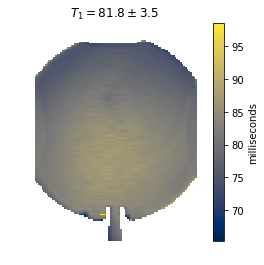

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(t2, cmap='cividis')
ax.axis('off')
cbar = fig.colorbar(im)
cbar.set_label('milliseconds')
ax.set_title(r'$T_1 = %0.1f \pm %0.1f$' % (np.nanmean(t2), np.nanstd(t2)));

This about 80ms which is fine.

So the approximate values are 900ms and 80ms for $T_1$ and $T_2$. That's fine, though the $T_1$ is little different from the previous phantom (we obtained 700ms and 80ms before).

### Alternative T2 fit using a log transform. 
We can also fit the decays by log transforming the data and doing an ordinary least squares regression. However, we should really weight the fit to account for the log transforming of the errors. We flatten the images and use the phantom foreground mask to subset the pixels for consideration.

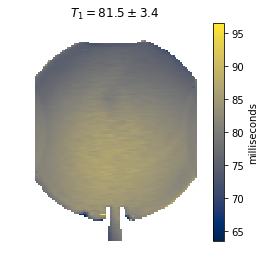

In [17]:
# Backgound for subtraction - probably not significant
bg = ((mean_image < 0.02 * np.median(mean_image)) * mean_image).mean()

# Flatten image and select only the foreground pixels
nte, ny, nx = vol.shape
vol_flat = vol.reshape(nte, -1)
mask_flat = mask.ravel()
vol_compressed = np.compress(mask_flat, vol_flat, axis=1)

# Check we don't have any zero pixels left
assert (vol_compressed <= 0).sum() == 0

# Log transform data
vol_log = np.log(vol_compressed - bg)

# Weighted, but can only do "average" weights as need to multiply design matrix
weights = np.sqrt(vol_compressed - bg).mean(axis=1)[:, np.newaxis]

# Design for linear regression
A = np.c_[np.ones_like(tes), tes]

# Fitting
result = np.linalg.lstsq(A*weights, vol_log*weights, rcond=None)[0]

# Unpack and reshape results
m0 = np.full_like(vol_flat[0], np.NAN)
m0[mask_flat] = np.exp(result[0])
m0 = m0.reshape((ny, nx))

t2 = np.full_like(vol_flat[0], np.NAN)
t2[mask_flat] = -1 / result[1]
t2 = t2.reshape((ny, nx))

# Plot the results
fig, ax = plt.subplots()
im = ax.imshow(t2, cmap='cividis')
ax.axis('off')
cbar = fig.colorbar(im)
cbar.set_label('milliseconds')
ax.set_title(r'$T_1 = %0.1f \pm %0.1f$' % (np.nanmean(t2), np.nanstd(t2)));

We obtain a similar result.